In [22]:
import numpy as np
import pandas as pd
import json
import os

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd

sns.set()

In [23]:
data = pd.read_csv('../data/old_dataset.csv', index_col=0)
data

,id,borough,neighborhood,longitude,latitude,population,number_of_restaurants,average_review_count,average_restaurant_rating,average_price_level,yelp_category
0,nyu_2451_34572.1,Bronx,Wakefield,-73.847201,40.894705,21242.0,13,169,4.0,1,caribbean
1,nyu_2451_34572.2,Bronx,Co-op City,-73.829939,40.874294,43752.0,12,771,4.0,2,delis
2,nyu_2451_34572.3,Bronx,Eastchester,-73.827806,40.887556,11506.0,19,532,4.1,1,caribbean
3,nyu_2451_34572.4,Bronx,Fieldston,-73.905643,40.895437,9287.0,9,297,4.4,1,N
4,nyu_2451_34572.5,Bronx,Riverdale,-73.912585,40.890834,9287.0,14,319,4.0,2,burgers
...,...,...,...,...,...,...,...,...,...,...,...
301,nyu_2451_34572.302,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0,20,848,4.3,2,newamerican
302,nyu_2451_34572.303,Queens,Hammels,-73.805530,40.587338,12295.0,17,257,4.3,2,chicken_wings
303,nyu_2451_34572.304,Queens,Bayswater,-73.765968,40.611322,25029.0,0,0,0.0,0,N
304,nyu_2451_34572.305,Queens,Queensbridge,-73.945631,40.756091,6677.0,17,222,4.1,2,tradamerican


In [3]:
# Define features
nfeatures = data.drop(['id','borough','neighborhood','longitude','latitude','yelp_category'], axis=1)
nfeatures

,population,number_of_restaurants,average_review_count,average_restaurant_rating,average_price_level
0,21242.0,13,169,4.0,1
1,43752.0,12,771,4.0,2
2,11506.0,19,532,4.1,1
3,9287.0,9,297,4.4,1
4,9287.0,14,319,4.0,2
...,...,...,...,...,...
301,23383.0,20,848,4.3,2
302,12295.0,17,257,4.3,2
303,25029.0,0,0,0.0,0
304,6677.0,17,222,4.1,2


In [4]:
nfeatures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 0 to 305
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   population                 306 non-null    float64
 1   number_of_restaurants      306 non-null    int64  
 2   average_review_count       306 non-null    int64  
 3   average_restaurant_rating  306 non-null    float64
 4   average_price_level        306 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 14.3 KB


In [5]:
# scaling
scaler = StandardScaler()
nfeatures_scaled = pd.DataFrame(scaler.fit_transform(nfeatures), columns=nfeatures.columns)
nfeatures_scaled

,population,number_of_restaurants,average_review_count,average_restaurant_rating,average_price_level
0,-0.242347,-0.392302,-0.762531,-0.037104,-1.127496
1,0.583073,-0.490618,1.151141,-0.037104,0.678859
2,-0.599356,0.197597,0.391394,0.098062,-1.127496
3,-0.680725,-0.785567,-0.355637,0.503559,-1.127496
4,-0.680725,-0.293985,-0.285702,-0.037104,0.678859
...,...,...,...,...,...
301,-0.163839,0.295913,1.395913,0.368393,0.678859
302,-0.570425,0.000964,-0.482792,0.368393,0.678859
303,-0.103481,-1.670415,-1.299758,-5.443739,-2.933852
304,-0.776431,0.000964,-0.594052,0.098062,0.678859


In [6]:
# correlation matrix
def plot_corr(df,size=5):
    """Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot
    """

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)

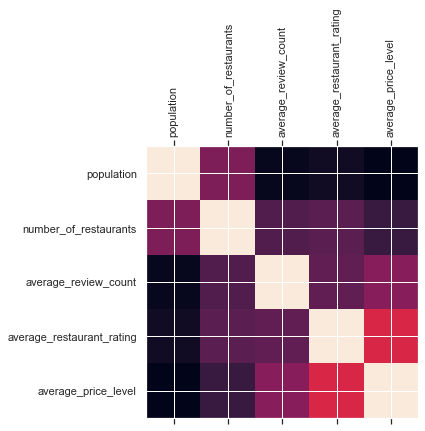

In [7]:
plot_corr(nfeatures_scaled)

In [8]:
# Let's figure out the best value for eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(nfeatures_scaled)

distances, indices = nbrs.kneighbors(nfeatures_scaled)

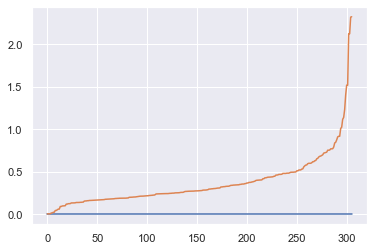

In [9]:
# plot it
distances = np.sort(distances, axis=0)
plt.plot(distances)

In [10]:
# between 0.5 and 1.0 seems best
dbscan = DBSCAN(
    eps=0.9,
    min_samples=5,
    n_jobs=-1
)

In [11]:
# fit and predict
clusters = pd.Series(dbscan.fit_predict(nfeatures_scaled))
clusters

0      0
1      1
2      0
3      0
4      1
      ..
301    1
302    1
303    2
304    1
305    0
Length: 306, dtype: int64

In [12]:
# Import GEOjson data

f = open('../data/data/nyc_geo.json')
nycgeo = json.load(f)
nycgeo['features']

[{'type': 'Feature',
  'id': 'nyu_2451_34572.1',
  'geometry': {'type': 'Point',
   'coordinates': [-73.84720052054902, 40.89470517661]},
  'geometry_name': 'geom',
  'properties': {'name': 'Wakefield',
   'stacked': 1,
   'annoline1': 'Wakefield',
   'annoline2': None,
   'annoline3': None,
   'annoangle': 0.0,
   'borough': 'Bronx',
   'bbox': [-73.84720052054902,
    40.89470517661,
    -73.84720052054902,
    40.89470517661]}},
 {'type': 'Feature',
  'id': 'nyu_2451_34572.2',
  'geometry': {'type': 'Point',
   'coordinates': [-73.82993910812398, 40.87429419303012]},
  'geometry_name': 'geom',
  'properties': {'name': 'Co-op City',
   'stacked': 2,
   'annoline1': 'Co-op',
   'annoline2': 'City',
   'annoline3': None,
   'annoangle': 0.0,
   'borough': 'Bronx',
   'bbox': [-73.82993910812398,
    40.87429419303012,
    -73.82993910812398,
    40.87429419303012]}},
 {'type': 'Feature',
  'id': 'nyu_2451_34572.3',
  'geometry': {'type': 'Point',
   'coordinates': [-73.82780644716412, 

In [13]:
# clustered_nfeatures = pd.concat([data['id'],clusters], axis=1)
# clustered_nfeatures.columns = ['id', 'clusters']

clustered_data = pd.concat([data,clusters], axis=1)

#name clusters column
clustered_data = clustered_data.rename(columns={0:'cluster'})

In [14]:
clustered_data

,id,borough,neighborhood,longitude,latitude,population,number_of_restaurants,average_review_count,average_restaurant_rating,average_price_level,yelp_category,cluster
0,nyu_2451_34572.1,Bronx,Wakefield,-73.847201,40.894705,21242.0,13,169,4.0,1,caribbean,0
1,nyu_2451_34572.2,Bronx,Co-op City,-73.829939,40.874294,43752.0,12,771,4.0,2,delis,1
2,nyu_2451_34572.3,Bronx,Eastchester,-73.827806,40.887556,11506.0,19,532,4.1,1,caribbean,0
3,nyu_2451_34572.4,Bronx,Fieldston,-73.905643,40.895437,9287.0,9,297,4.4,1,N,0
4,nyu_2451_34572.5,Bronx,Riverdale,-73.912585,40.890834,9287.0,14,319,4.0,2,burgers,1
...,...,...,...,...,...,...,...,...,...,...,...,...
301,nyu_2451_34572.302,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0,20,848,4.3,2,newamerican,1
302,nyu_2451_34572.303,Queens,Hammels,-73.805530,40.587338,12295.0,17,257,4.3,2,chicken_wings,1
303,nyu_2451_34572.304,Queens,Bayswater,-73.765968,40.611322,25029.0,0,0,0.0,0,N,2
304,nyu_2451_34572.305,Queens,Queensbridge,-73.945631,40.756091,6677.0,17,222,4.1,2,tradamerican,1


In [20]:
# Define mapbox token
maptoken = os.environ["MAPBOX_TOKEN"]

# plot points and color by cluster
fig = px.scatter_mapbox(clustered_data, lat='latitude', lon='longitude', hover_name='neighborhood', color='cluster',
                        height=500)
fig.update_geos(fitbounds="locations")
fig.update_layout(mapbox_style="dark", mapbox_accesstoken=maptoken, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()